# VAE

In [1]:
from model import VAE

import tensorflow as tf
import keras as K
import numpy as np
import os

### Data Preprocessing

In [2]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = tf.cast(mnist_digits, tf.float64) / 255.0
mnist_digits = np.expand_dims(mnist_digits, -1)

2025-09-23 15:49:25.820507: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-09-23 15:49:25.820536: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-09-23 15:49:25.820540: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
I0000 00:00:1758664165.820779  924319 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1758664165.820968  924319 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Training the VAE

In [3]:
vae = VAE(image_size=28, channels=1, latent_dim=2)
vae.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))
callbacks = vae.get_callbacks(log_dir="logs", patience=7)
vae.fit(mnist_digits, epochs=50, batch_size=256, callbacks=callbacks)

Epoch 1/50


2025-09-23 15:49:26.937561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


274/274 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - kl_loss: 0.0018 - loss: 541.2805 - reconstruction_loss: 541.2792   
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - kl_loss: 1.1848 - loss: 529.0247 - reconstruction_loss: 527.8397
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - kl_loss: 17.8735 - loss: 464.6458 - reconstruction_loss: 446.7722
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - kl_loss: 33.9627 - loss: 332.1335 - reconstruction_loss: 298.1708
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - kl_loss: 25.6671 - loss: 275.3522 - reconstruction_loss: 249.6852
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - kl_loss: 19.4298 - loss: 250.5346 - reconstruction_loss: 231.1049
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - kl_loss: 15.4709 - loss: 237.0691 - reconstruction_loss: 221.5983
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - kl_loss: 12.5487 - loss: 228.5553 - reconstruction_loss: 216.0066
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━

In [4]:
for metric in vae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 210.3147735595703
reconstruction_loss: 198.2139129638672
kl_loss: 12.100910186767578


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [5]:
# Save
os.makedirs("./weights", exist_ok=True)
vae.encoder.save("./weights/encoder.keras")
vae.decoder.save("./weights/decoder.keras")

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


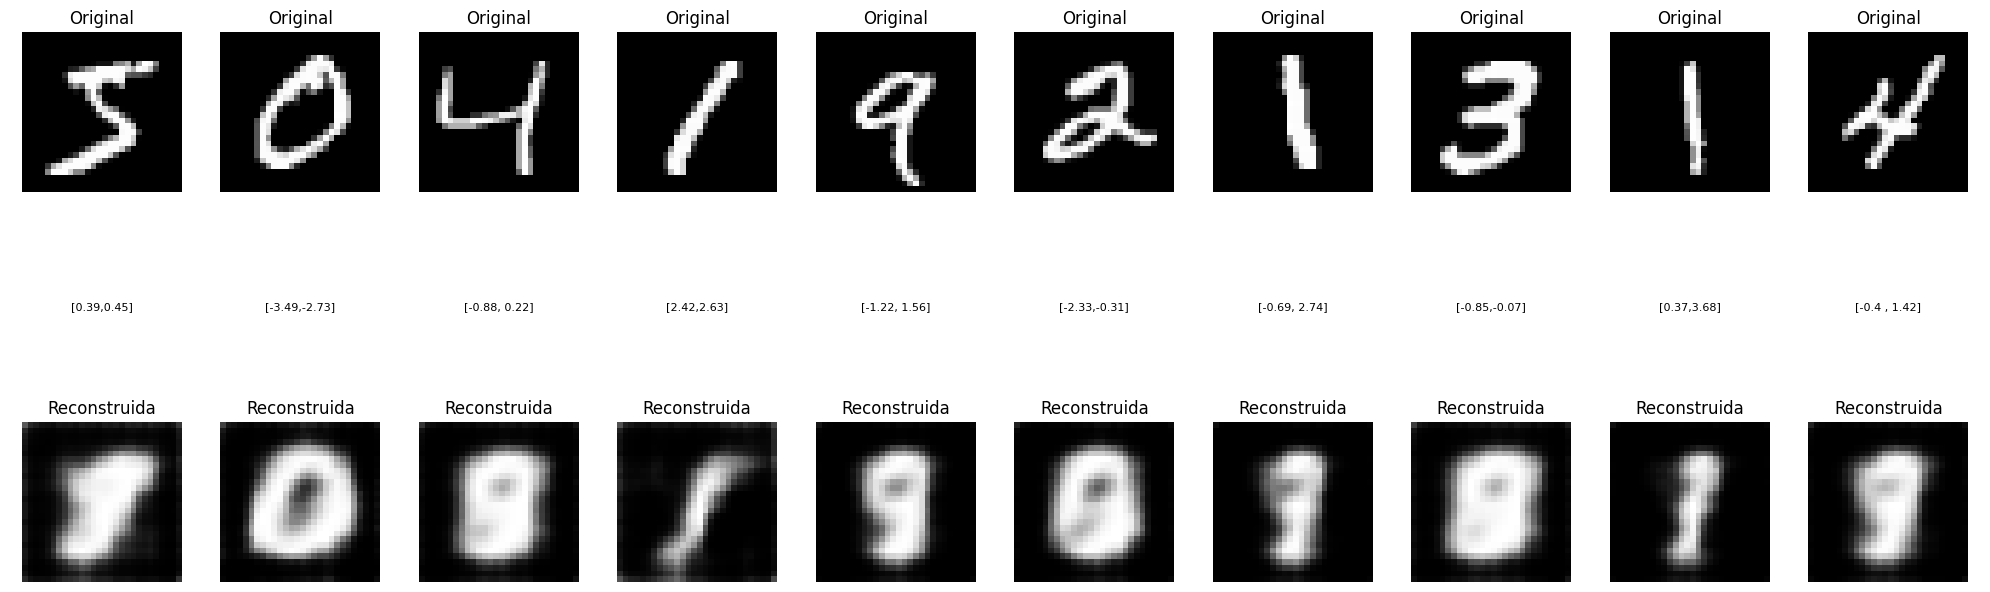

In [6]:
import matplotlib.pyplot as plt

n = 10
example_images = mnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae.encoder.predict(example_images)
predictions = vae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    ax = plt.subplot(3, n, i + 1 + n)
    ax.axis("off")
    z_text = np.array2string(z[i], precision=2, separator=",")
    ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


## CelebA Dataset

In [7]:
# Import TFDS to download CelebA

import tensorflow_datasets as tfds

# Automatic download
#celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
#celeb_a_builder.download_and_prepare()

# If downloading manually
celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
celeb_a_builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir="../datasets/"))

In [8]:
# Cargar splits de train y test
celeb_a_train = celeb_a_builder.as_dataset(split='train', shuffle_files=True)
celeb_a_test = celeb_a_builder.as_dataset(split='test', shuffle_files=True)

In [9]:
def preprocess_celeba(example):
    image = tf.cast(example['image'], tf.float64) / 255.0
    image = tf.image.resize(image, [64, 64])
    return image

batch_size = 256

celeb_a_train_batched = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
celeb_a_test_batched = celeb_a_test.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [10]:

vae2 = VAE(image_size=64, channels=3, latent_dim=256)

# Debemos reemplazar el decoder para que produzca imágenes de 64x64x3
latent_inputs = K.layers.Input(shape=(vae2.latent_dim,))
x = K.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = K.layers.Reshape((8, 8, 64))(x)
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 32x32
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 64x64
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
vae2.decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vae2.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))
callbacks2 = vae2.get_callbacks(log_dir="logs", patience=3)
vae2.fit(celeb_a_train_batched, epochs=50, callbacks=callbacks2)

Epoch 1/50


/Users/roicort/GitHub/VAE-VQ-VAE/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['dense_5/kernel', 'dense_5/bias', 'conv2d_transpose_3/kernel', 'conv2d_transpose_3/bias', 'conv2d_transpose_4/kernel', 'conv2d_transpose_4/bias', 'conv2d_transpose_5/kernel', 'conv2d_transpose_5/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
2025-09-23 15:54:31.268770: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


636/636 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - kl_loss: 0.1843 - loss: 2825.5171 - reconstruction_loss: 2825.3359
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 78s 123ms/step - kl_loss: 14.7409 - loss: 2668.7217 - reconstruction_loss: 2653.9800
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - kl_loss: 17.7411 - loss: 2578.8179 - reconstruction_loss: 2561.0771
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 79s 124ms/step - kl_loss: 19.5493 - loss: 2544.0979 - reconstruction_loss: 2524.5488
Epoch 5/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - kl_loss: 22.6301 - loss: 2460.4812 - reconstruction_loss: 2437.8496
Epoch 6/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - kl_loss: 26.0385 - loss: 2400.6235 - reconstruction_loss: 2374.5850
Epoch 7/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 183s 289ms/step - kl_loss: 30.3932 - loss: 2377.6980 - reconstruction_loss: 2347.3035
Epoch 8/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 941s 1s/step - kl_loss: 36.5680 - loss: 2366.3342 - reconstruction_loss: 2329.7673
Epoch 9/50
63

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


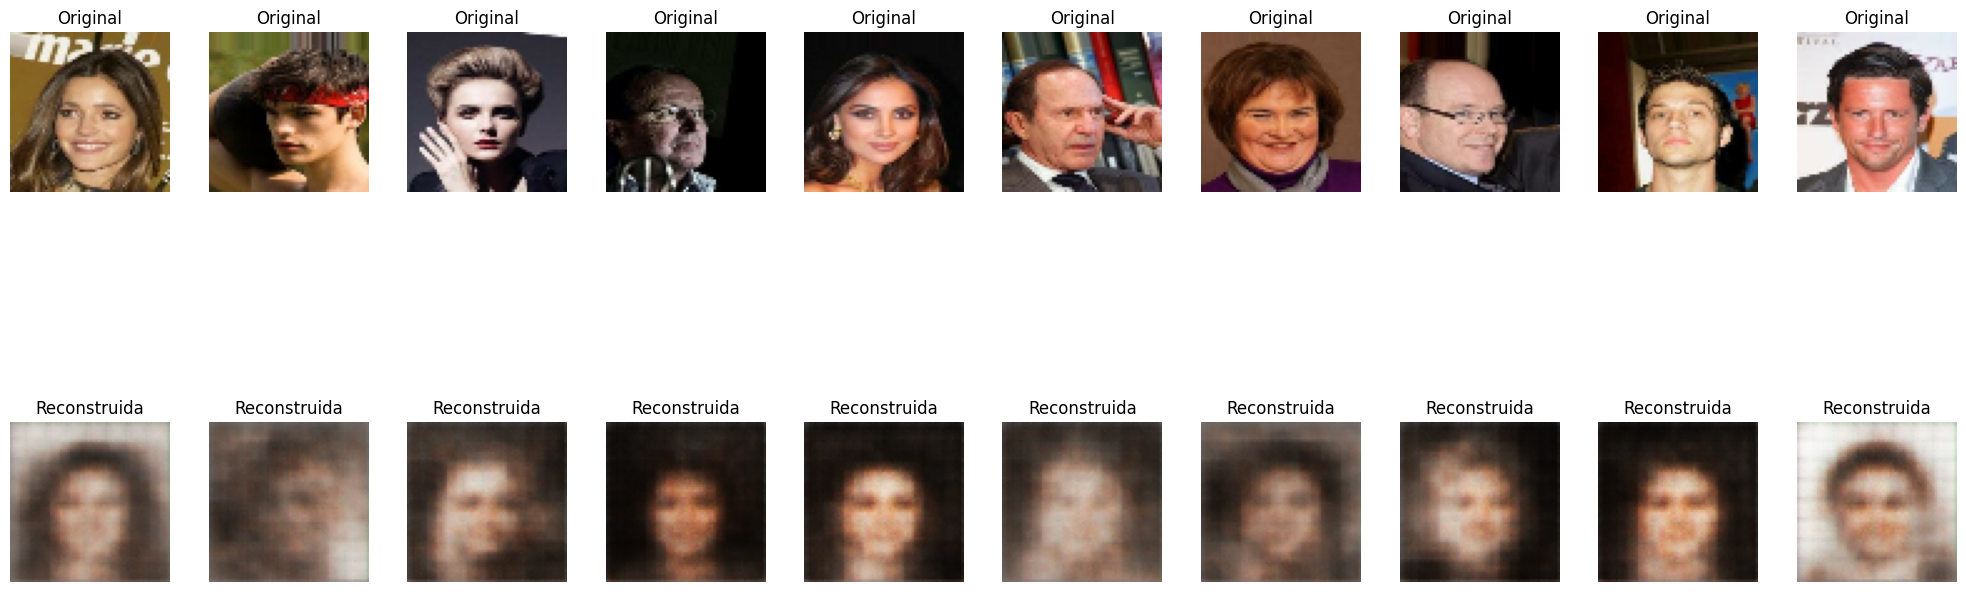

In [11]:
import matplotlib.pyplot as plt

n = 10
images_list = []
for batch in celeb_a_test_batched:
    for img in batch:
        images_list.append(img.numpy())
        if len(images_list) == n:
            break
    if len(images_list) == n:
        break
images = np.stack(images_list)  # shape (n, 64, 64, 3)

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae2.encoder.predict(images)
predictions = vae2.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i].squeeze())
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze())
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()
